  Preparing metadata (setup.py) ... done


[*********************100%***********************]  1 of 1 completed


🔍 Random Forest Report:
               precision    recall  f1-score   support

           0       0.44      0.82      0.57       148
           1       0.60      0.20      0.30       194

    accuracy                           0.47       342
   macro avg       0.52      0.51      0.44       342
weighted avg       0.53      0.47      0.42       342

🔍 XGBoost Report:
               precision    recall  f1-score   support

           0       0.44      0.69      0.53       148
           1       0.57      0.32      0.41       194

    accuracy                           0.48       342
   macro avg       0.50      0.50      0.47       342
weighted avg       0.51      0.48      0.46       342



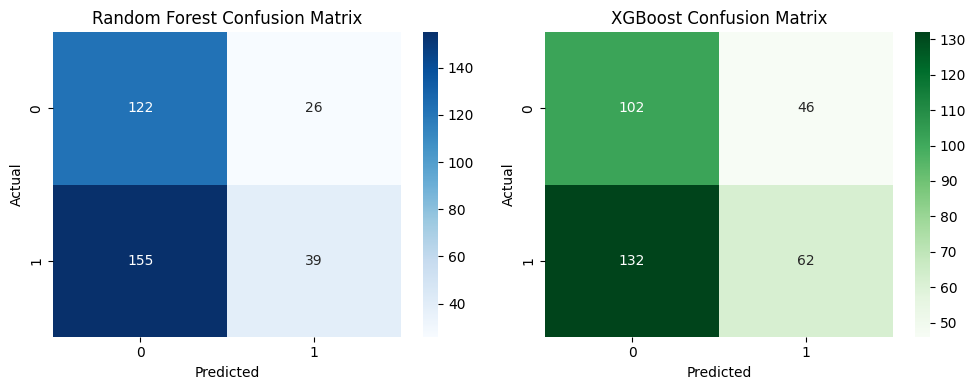

In [ ]:
#CONFUSIONMATRIX Program project
# STEP 1: Install Required Libraries
!pip install yfinance ta scikit-learn xgboost --quiet

# STEP 2: Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# STEP 3: Load Stock Data
data = yf.download("AAPL", start="2018-01-01", end="2024-12-31")
data = data[['Close']].dropna()
data['Return'] = data['Close'].pct_change()
data.dropna(inplace=True)

# ✅ STEP 4: Add Technical Indicators (Fully FIXED)
close_series = data['Close'].squeeze()  # Ensure this is a 1D Series

data['SMA_10'] = close_series.rolling(window=10).mean()
data['SMA_50'] = close_series.rolling(window=50).mean()
data['RSI'] = RSIIndicator(close=close_series, window=14).rsi()
data['MACD'] = MACD(close=close_series).macd()

bb = BollingerBands(close=close_series)
data['BB_High'] = bb.bollinger_hband()
data['BB_Low'] = bb.bollinger_lband()

data.dropna(inplace=True)

# STEP 5: Create Target (1 if next day price is higher, else 0)
data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)
data.dropna(inplace=True)

# STEP 6: Define Features and Target
features = ['SMA_10', 'SMA_50', 'RSI', 'MACD', 'BB_High', 'BB_Low', 'Return']
X = data[features]
y = data['Target']

# STEP 7: Train-Test Split (No shuffle for time series)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# STEP 8: Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# STEP 9: Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

# STEP 10: Evaluation
print("🔍 Random Forest Report:\n", classification_report(y_test, rf_preds))
print("🔍 XGBoost Report:\n", classification_report(y_test, xgb_preds))

# STEP 11: Confusion Matrix Plot
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, fmt='d', cmap='Greens')
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()